# Imports

In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow import keras
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, cosine_distances
from math import ceil
import numpy as np
import cv2
import random
import os

%matplotlib inline

# Select Model

Specify model to use for extracting feature vectors of images. List of possible models, and descriptions of models are from [Keras Applications](https://keras.io/applications).

In [35]:
name = 'MobileNetV2'
pooling = None

if name == 'NASNetLarge':
    input_width = 331
    input_height = 331
    model = keras.applications.nasnet.NASNetLarge(
        input_shape=(input_width, input_height, 3), 
        include_top=False, 
        weights='imagenet', 
        pooling=pooling)
elif name == 'NASNetMobile':
    input_width = 224
    input_height = 224
    model = keras.applications.nasnet.NASNetMobile(
        input_shape=(input_width, input_height, 3), 
        include_top=False, 
        weights='imagenet', 
        pooling=pooling)
elif name == 'InceptionResNetV2':
    input_width = 299
    input_height = 299
    model = keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape=(input_width, input_height, 3), 
        include_top=False,
        weights='imagenet', 
        pooling=pooling)
elif name == 'InceptionV3':
    input_width = 299
    input_height = 299
    model = keras.applications.inception_v3.InceptionV3(
        input_shape=(input_width, input_height, 3), 
        include_top=False,
        weights='imagenet', 
        pooling=pooling)
elif name == 'Xception':
    input_width = 299
    input_height = 299
    model = keras.applications.xception.Xception(
        input_shape=(input_width, input_height, 3), 
        include_top=False,
        weights='imagenet', 
        pooling=pooling)
elif name == 'MobileNetV2':
    input_width = 224
    input_height = 224
    model = keras.applications.mobilenet_v2.MobileNetV2(
        input_shape=(input_width, input_height, 3), 
        include_top=False,
        weights='imagenet', 
        pooling=pooling)
    
if pooling == None:
    last_output = model.output
    x = layers.Flatten()(last_output)
    model = Model(model.input, x)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

# Load Photos

Load and resize photos from specified directories.

In [36]:
dir_0 = 'yelp_photos/0/'
dir_1 = 'yelp_photos/1/'

ims_0 = os.listdir(dir_0)
ims_1 = os.listdir(dir_1)

all_ims = ims_0 + ims_1

im_batch = []
labels = []

for im_name in ims_0:
    im = cv2.imread(dir_0 + im_name)
    im_resize = cv2.cvtColor(cv2.resize(im, dsize=(input_width, input_height), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)
    im_batch.append(im_resize)
    labels.append(0)
        
for im_name in ims_1:
    im = cv2.imread(dir_1 + im_name)
    im_resize = cv2.cvtColor(cv2.resize(im, dsize=(input_width, input_height), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)
    im_batch.append(im_resize)
    labels.append(1)
    
im_batch = np.array(im_batch)
print(im_batch.shape)

(1640, 224, 224, 3)


# Extract Features

In [37]:
predictions = model.predict(im_batch, verbose=1)
print(predictions.shape)

1640/1640 [==============================] - 40s 24ms/sample
(1640, 62720)


# Find Similar Images

### Similarity Metrics

Use similarity metrics like cosine distance, mangattan distance, and euclidean distance to find the most similar feature vectors for a given feature vector.

In [38]:
def get_similar_images(percentile):
    base_prediction = predictions[base_index].reshape(1, predictions.shape[1])

    if sim_metric == 'Cosine_Distance':
        distances = cosine_distances(predictions, base_prediction)
    elif sim_metric == 'Manhattan_Distance':
        distances = manhattan_distances(predictions, base_prediction)
    elif sim_metric == 'Euclidean_Distance':
        distances = euclidean_distances(predictions, base_prediction)

    threshold = np.percentile(distances, percentile)
    sim_indexes = np.argwhere(distances < threshold)
    sim_indexes = np.delete(sim_indexes, np.argwhere(sim_indexes == base_index)[0][0], axis=0)
    
    sorted_dist = []
    for i in range(len(sim_indexes)):
        index = sim_indexes[i][0]
        sorted_dist.append([index, distances[index][0]])

    sorted_dist = sorted(sorted_dist, key=lambda l:l[1])
    
    return sorted_dist

### Plot Similar Images

Plot the original images along with its similar images, sorted by similarity.

In [43]:
def show_similar_images(subplot_height, suptitle_y):
    plt.imshow(im_batch[base_index])
    plt.title('Original')
    plt.axis('on')

    plt.figure(figsize=(15,subplot_height))
    plt.subplots_adjust(hspace=0.8, wspace=1)
    sim_labels = []

    for i in range(len(sorted_dist)):
        index = sorted_dist[i][0]
        sim_labels.append(labels[index])
        plt.subplot(ceil(len(sorted_dist)/4),4,i+1)
        plt.imshow(im_batch[index])
        title = all_ims[index] + '\nDistance: ' + str(round(sorted_dist[i][1], 5)) + '\nLabel: ' + str(labels[index])
        plt.title(title)
        plt.axis('off')

    _ = plt.suptitle(sim_metric, fontsize=16, y=suptitle_y)
    print('Predicted:', sum(sim_labels) / len(sim_labels))
    print('Actual:', labels[base_index])

# Example 1

Find similar images for massage business storefronts.

Predicted: 0.5625
Actual: 1


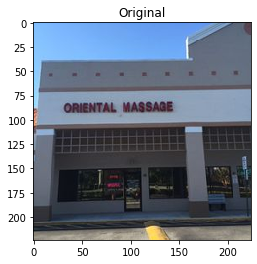

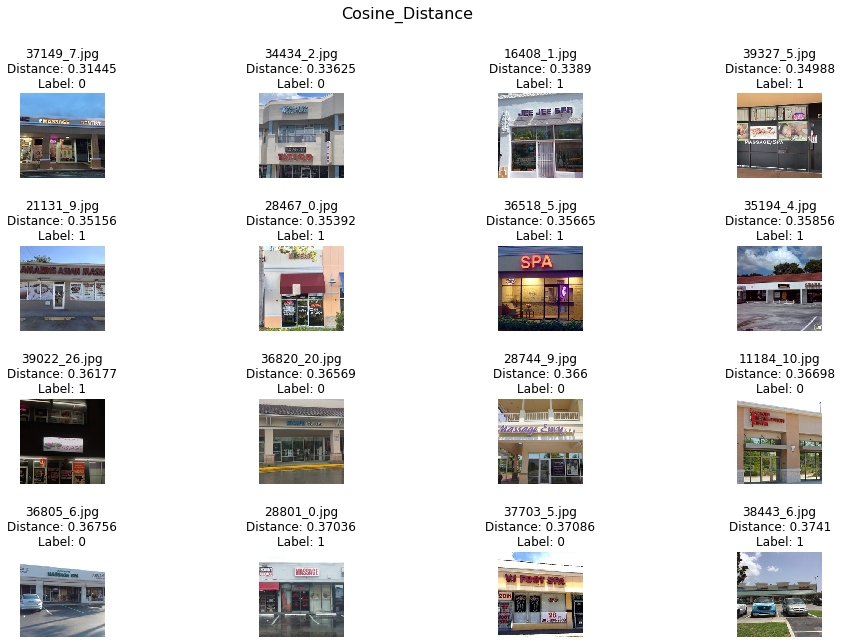

In [44]:
im_name = '29285_4.jpg'
base_index = all_ims.index(im_name)
sim_metric = 'Cosine_Distance'

sorted_dist = get_similar_images(percentile=1)
show_similar_images(subplot_height=10, suptitle_y=1)

# Example 2

Find similar images for massage business logos.

Predicted: 0.25
Actual: 0


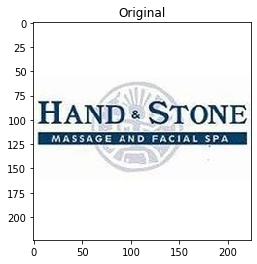

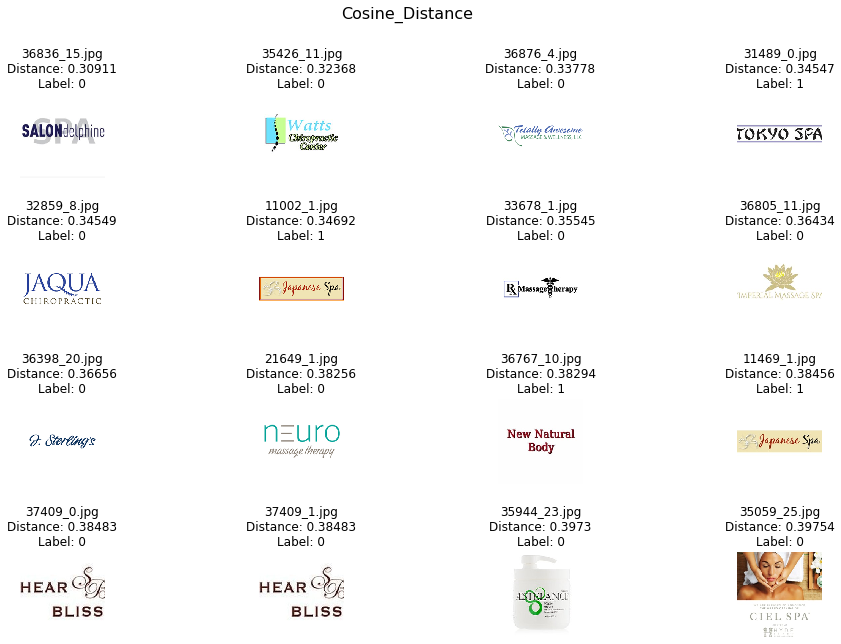

In [45]:
im_name='34453_10.jpg'
base_index = all_ims.index(im_name)
sim_metric = 'Cosine_Distance'

sorted_dist = get_similar_images(percentile=1)
show_similar_images(subplot_height=10, suptitle_y=1)

# Example 3

Find similar images for faces.

Predicted: 0.5
Actual: 0


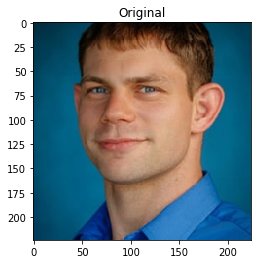

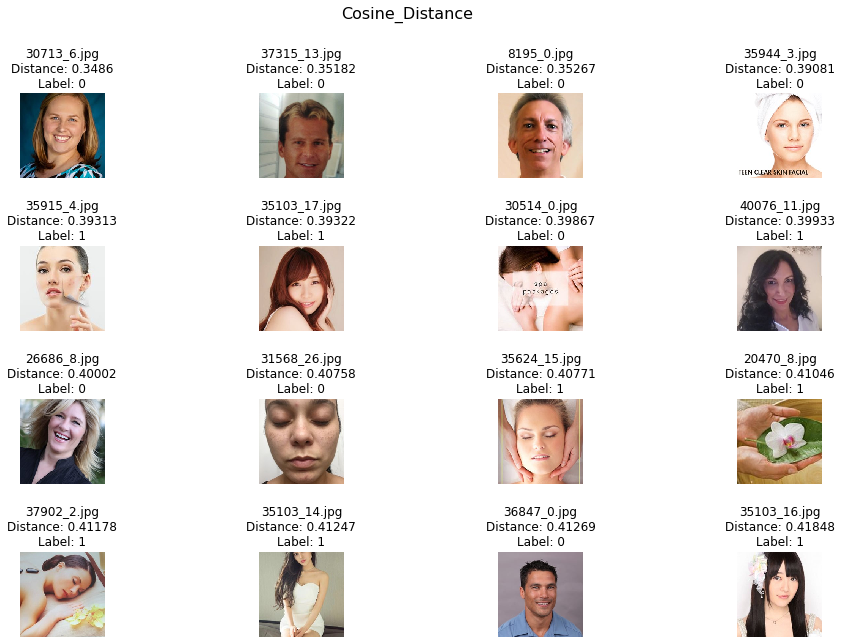

In [57]:
im_name='30713_4.jpg'
base_index = all_ims.index(im_name)
sim_metric = 'Cosine_Distance'

sorted_dist = get_similar_images(percentile=1)
show_similar_images(subplot_height=10, suptitle_y=1)

# Test Random Image

Find similar images for a random image

Predicted: 0.5625
Actual: 1


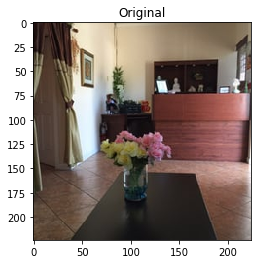

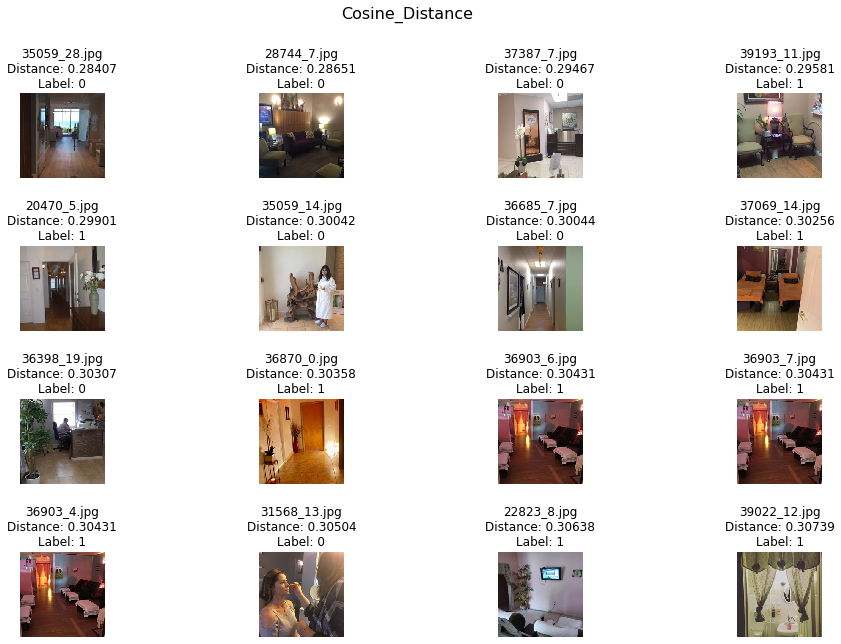

In [142]:
base_index = random.randint(0, len(all_ims)-1)
sim_metric = 'Cosine_Distance'

sorted_dist = get_similar_images(percentile=1)
show_similar_images(subplot_height=10, suptitle_y=1)